In [65]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import numpy as np
import math, random

from models.nalu import NeuralArithmeticLogicUnitCell

import matplotlib.pyplot as plt
import time
%matplotlib inline
import time
import pylab as pl
from IPython import display

In [334]:
def generate_recurrent_synthetic_arithmetic_dataset(arithmetic_op, min_value, max_value, sample_size, sequence_size, set_size, boundaries = None):
    """
    generates a dataset of integers for the synthetics arithmetic task

    :param arithmetic_op: the type of operation to perform on the sum of the two sub sections can be either :
    ["add" , "subtract", "multiply", "divide", "root", "square"]
    :param min_value: the minimum possible value of the generated integers
    :param max_value: the maximum possible value of the generated integers
    :param sample_size: the number of integers per sample
    :param set_size: the number of samples in the dataset
    :param boundaries: [Optional] an iterable of 4 integer indices in the following format :
    [start of 1st section, end of 1st section, start of 2nd section, end of 2nd section]
    if None, the boundaries are randomly generated.
    :return: the training dataset input, the training true outputs, the boundaries of the sub sections used
    """
    a_exp = []
    b_exp = []
    outs = []
    
    if boundaries is None:
        boundaries = [np.random.randint(sample_size) for i in range(4)]
        while len(np.unique(boundaries)) != 4:
            boundaries = [np.random.randint(sample_size) for i in range(4)]
            
        boundaries = sorted(boundaries)
        
        if boundaries[1] == boundaries[0]:
            if boundaries[1] < sample_size-1:
                boundaries[1] =boundaries[1]+ 1
            else:
                boundaries[0] = boundaries[0] - 1
                
        if boundaries[3] == boundaries[2]:
            if boundaries[3] < sample_size-1:
                boundaries[3] =boundaries[3]+ 1
            else:
                boundaries[2] =boundaries[2]- 1
    else:
        if len(boundaries) != 4:
            raise ValueError("boundaries is expected to be a list of 4 elements but found {}".format(len(boundaries)))
    
    x = np.random.uniform(min_value, max_value, (set_size, sample_size,sequence_size))

    for exp in range(set_size):
        a = []
        b = []
        for time in range(sequence_size):
            if time == 0:
                a.append(sum(x[exp, boundaries[0]:boundaries[1], time]))
                b.append(sum(x[exp, boundaries[2]:boundaries[3], time]))
            else:
            
                a.append(sum(sum(x[exp, boundaries[0]:boundaries[1], time-1:time+1])))
                b.append(sum(sum(x[exp, boundaries[2]:boundaries[3], time-1:time+1])))
                
        a_exp.append(a)
        b_exp.append(b)
    
    a_exp = np.array(a_exp)
    b_exp = np.array(b_exp)

    if "add" in str.lower(arithmetic_op):
        true_outputs = a_exp + b_exp
        

    x = torch.tensor(x, dtype=torch.float32)
    true_outputs = torch.tensor(true_outputs, dtype=torch.float32).unsqueeze(1)
    
    return x, true_outputs, boundaries


In [335]:
arithmetic_op = 'add'
min_value = 1
max_value  = 10
sample_size = 6
sequence_size = 3
number_of_experiments = 1

inputs, targets, boundaries = generate_recurrent_synthetic_arithmetic_dataset(
                                                arithmetic_op, min_value, max_value, 
                                                sample_size, sequence_size,
                                                number_of_experiments)
print(inputs)
print(boundaries)    
print(targets)

tensor([[[ 4.9004,  7.8999,  8.6827],
         [ 2.8161,  3.1335,  3.8262],
         [ 8.9773,  2.3877,  3.7469],
         [ 8.5907,  1.5491,  9.7664],
         [ 8.4603,  8.5113,  5.5960],
         [ 5.5834,  8.4668,  8.2704]]])
[0, 1, 2, 3]
tensor([[[ 13.8777,  24.1653,  22.7172]]])


In [381]:
class NaluRNN(nn.Module):
    def __init__(self):
        super(NaluRNN, self).__init__()
        
        self.feature_size = 100
        self.hidden_size = 2
        self.output_size = 1
        
        self.selector = NeuralArithmeticLogicUnitCell(self.feature_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size,self.output_size)
        #self.linear = 
        self.operator = NeuralArithmeticLogicUnitCell(self.hidden_size,self.output_size)
    
    def step(self, x, hidden=None):

        x_t = self.selector(x)

        h_t = self.linear(torch.cat((x_t,hidden),dim=0))
        h_t = torch.t(h_t)
        #h_t = x_t + (hidden) # this is equal to have a w = [1,1]

        y_t = self.operator(h_t)
        
        return y_t, h_t
    
    def forward(self, inputs, hidden=None):

        steps = np.shape(inputs)[1]

        outputs = Variable(torch.zeros(steps))
        
        for i in range(steps):
            if i == 0:
                hidden = torch.zeros(1,2)

            output, hidden = self.step(inputs[:,i].unsqueeze(0), hidden)
            outputs[i] = output
            
        return outputs


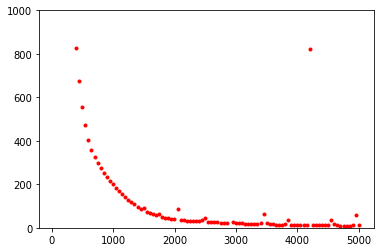

In [404]:
arithmetic_op = 'add'
min_value = 1
max_value  = 10
sample_size = 100
sequence_size = 10
number_of_experiments = 10

inputs, targets, boundaries = generate_recurrent_synthetic_arithmetic_dataset(
                                                arithmetic_op, min_value, max_value, 
                                                sample_size, sequence_size,
                                                number_of_experiments)

inputs_test, targets_test, _ = generate_recurrent_synthetic_arithmetic_dataset(
                                                arithmetic_op, min_value, max_value, 
                                                sample_size, sequence_size,
                                                number_of_experiments, boundaries)

n_epochs = 5000

model = NaluRNN()
criterion = nn.MSELoss()
#optimizer = optim.RMSprop(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr = 0.005)
losses = np.zeros(n_epochs) # For plotting
    
for epoch in range(n_epochs):
    losses = []
    model.train()
    for iter in range(number_of_experiments):
    
        input_ = inputs[iter, :, :]
        target_ = targets[iter, :, :]

        outputs = model(input_)

        optimizer.zero_grad()
        loss = criterion(outputs, target_.squeeze(0))
        loss.backward()
        optimizer.step()

        losses.append(loss.data)
        
    if epoch % 50 ==49:
        model.eval()
        test_losses = []
        for iter in range(number_of_experiments):
            outputs = model(inputs_test[iter,:,:])
            loss = criterion(outputs, targets_test[iter,:,:].squeeze(0))
            test_losses.append(loss.data)
            
        plt.ylim([0,1000])
        plt.plot(epoch,np.mean(losses),'r.')
        plt.plot(epoch,np.mean(test_losses), 'b.')
        display.display(pl.gcf())
        display.clear_output(wait=True)


In [394]:
np.mean(losses)


2.2138701e-07